https://discourse.pymc.io/t/gaussian-mixture-of-regression/537

In [1]:
%pylab inline
import pymc3 as pm
import numpy as np
import pandas as pd
import seaborn as sns
import theano.tensor as tt

%config InlineBackend.figure_format = 'retina'
plt.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])
sns.set_color_codes()
C0, C1 = sns.color_palette()[:2]

Populating the interactive namespace from numpy and matplotlib


# Display raw data

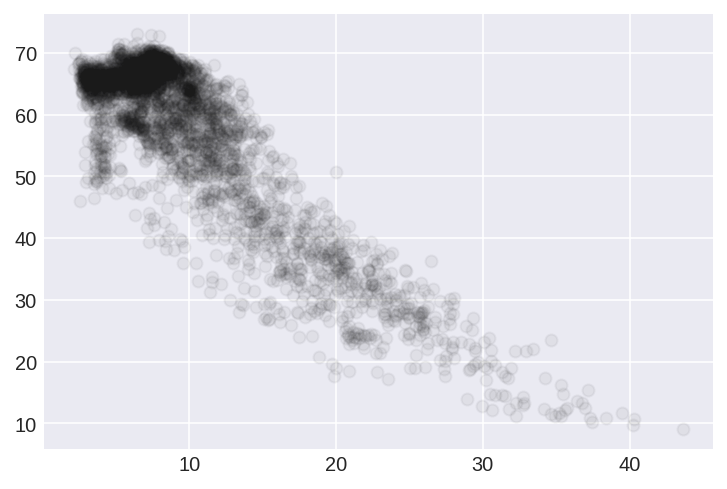

In [2]:
df = pd.read_csv('mixture.csv')
X = df['X'].values
Y = df['Y'].values
plt.scatter(X, Y, alpha=.05, color='k');

# Marginalized mixture

In [3]:
k = 2 
with pm.Model() as gmm1:
    # Priors for weight parameter
    π = pm.Dirichlet('π', np.array([1]*k), testval=np.ones(k)/k)
    
    # Priors for unknown model parameters
    α = pm.Normal('α', mu=0, sd=100, shape=k, 
                  testval=np.array([Y.mean()]*2)) #Intercept
    β = pm.Normal('β', mu=0, sd=100, shape=k)
    σ  = pm.HalfCauchy('σ', 5, shape=k)  #Noise
    
    mu = α + X[:,None]*β
        
    likelihood = pm.NormalMixture('likelihood', π, mu, sd=σ, observed=Y)
    trace1 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ_log__, β, α, π_stickbreaking__]
100%|██████████| 2000/2000 [00:21<00:00, 95.13it/s]


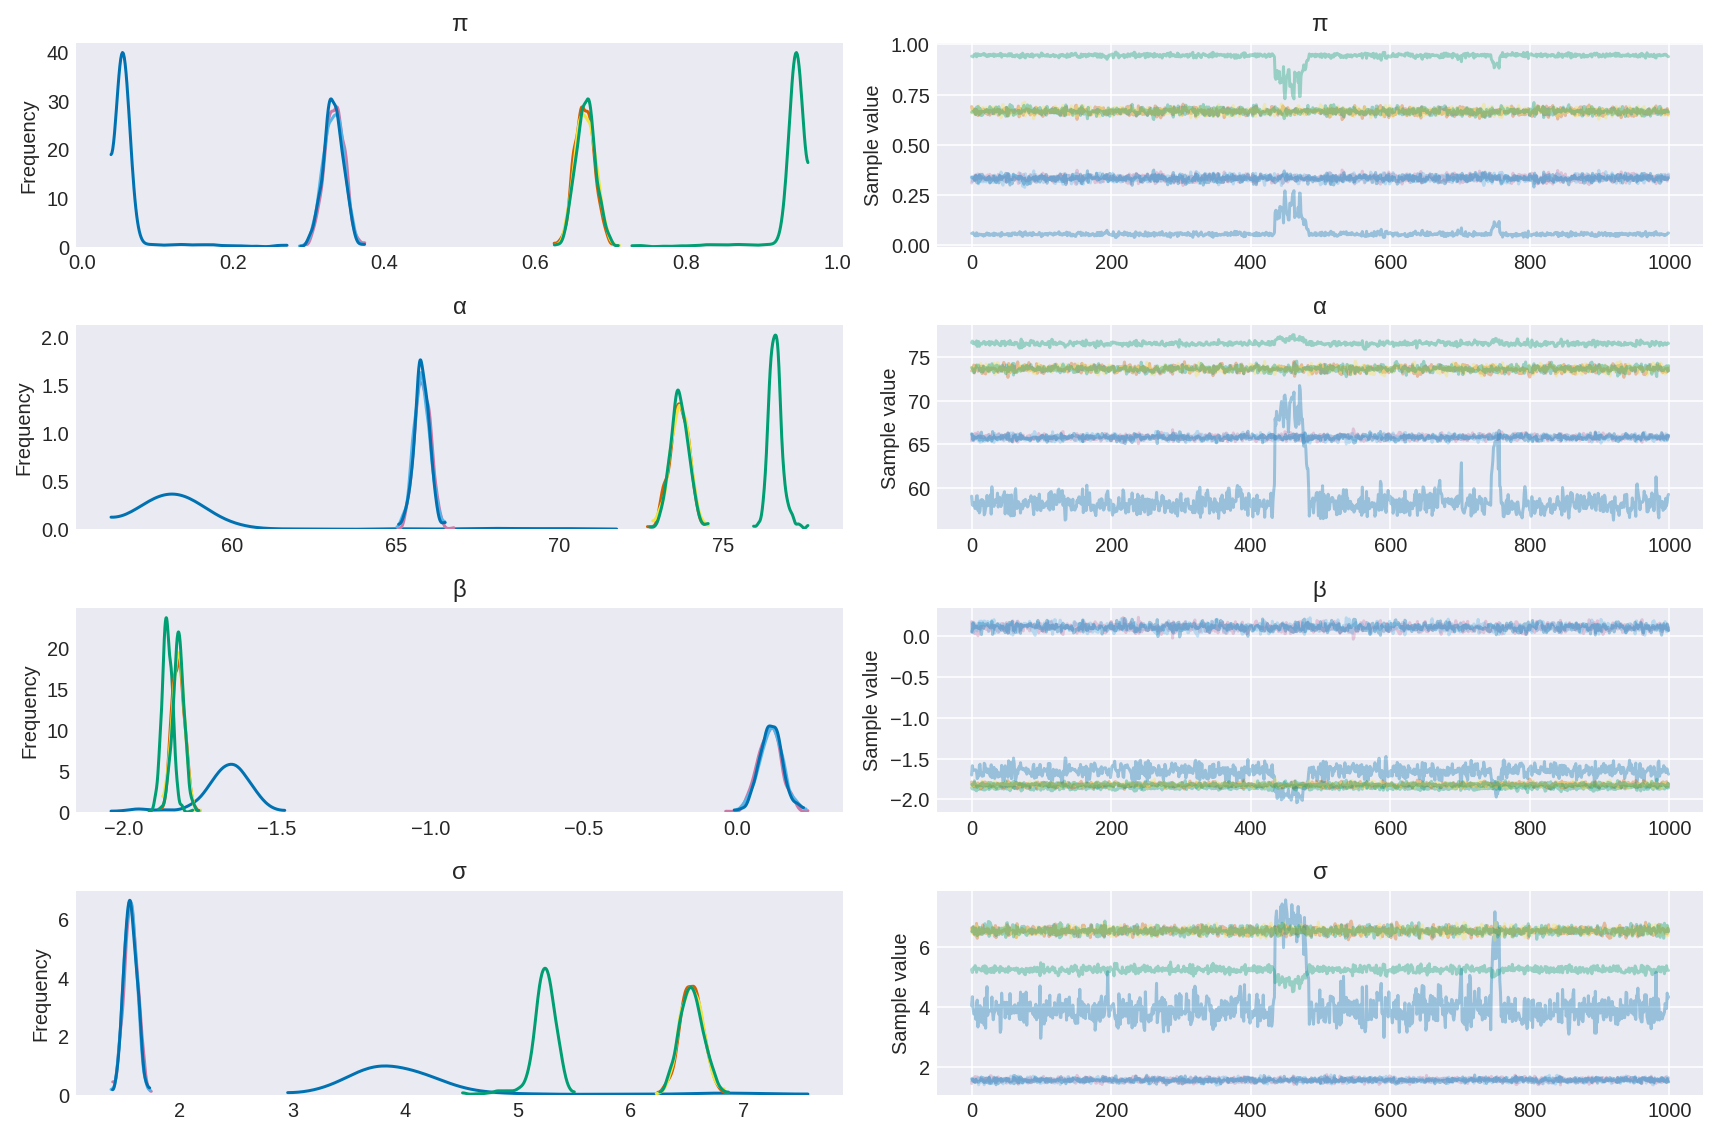

In [4]:
pm.traceplot(trace1, varnames=['π', 'α', 'β', 'σ']);

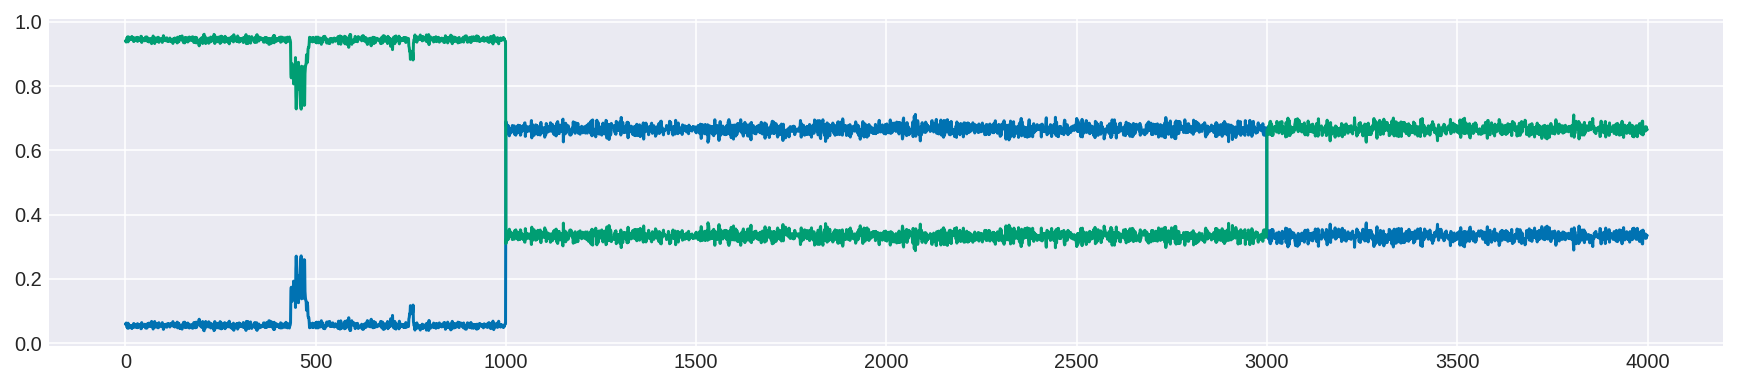

In [5]:
_, ax = plt.subplots(1, 1, figsize=(15, 3))
plt.plot(trace1.get_values(varname='π'));

### Since there are label switching, the summary function does not work in this case

In [6]:
pm.summary(trace1, varnames=['π', 'α', 'β', 'σ']).round(2)

mean    sd  mc_error  hpd_2.5  hpd_97.5  n_eff   Rhat
π__0   0.43  0.25      0.03     0.05      0.69    2.0  16.49
π__1   0.57  0.25      0.03     0.31      0.95    2.0  16.49
α__0  67.98  6.34      0.63    57.38     74.20    2.0   5.95
α__1  70.48  4.79      0.48    65.39     76.83    2.0  22.36
β__0  -1.30  0.82      0.08    -1.86      0.15    2.0  19.33
β__1  -0.87  0.97      0.10    -1.89      0.16    2.0  37.59
σ__0   4.68  2.10      0.21     1.47      6.70    2.0   6.44
σ__1   3.72  2.21      0.22     1.45      6.65    2.0  28.86

Switch label by hand

In [11]:
def diag_switch(mtrace, labelswitch, rmchain, varnames, diagfunc):
    Stat_ = {}
    nchain = mtrace.nchains
    nsamp = len(mtrace)
    
    for var in varnames:
        post_ = mtrace.get_values(varname=var, combine=False)
        x = np.copy(post_)
        for il in labelswitch:
            x[il][:,[0, 1]] = post_[il][:,[1, 0]]
        mask = np.ones_like(x).astype(bool)
        mask[np.s_[rmchain,:,:]] = False
        x = x[mask].reshape((nchain-len(rmchain)), len(mtrace), -1)
        num_samples = x.shape[1]
        Stat_[var] = diagfunc(np.asarray(x), num_samples)
        
    return Stat_

labelswitch = [3]
rmchain = [0]

In [12]:
diag_switch(trace1, labelswitch, rmchain, ['π', 'α', 'β', 'σ'], pm.gelman_rubin)

{'α': array([ 1.00006549,  1.00252131]),
 'β': array([ 0.9996797 ,  1.00231731]),
 'π': array([ 1.00243004,  1.00243004]),
 'σ': array([ 0.99957594,  1.00088734])}

In [13]:
diag_switch(trace1, labelswitch, rmchain, ['π', 'α', 'β', 'σ'], pm.effective_n)

{'α': array([ 1699.,  1641.]),
 'β': array([ 2051.,  1597.]),
 'π': array([ 2126.,  2126.]),
 'σ': array([ 3000.,  2296.])}

In [24]:
# Get posterior prediction of each observation in Y
nchain = trace1.nchains
nsamp = len(trace1)
category_post = np.zeros(((nchain-len(rmchain))*nsamp, Y.shape[0]))

post_dict = dict()
varnames=['α', 'β', 'σ']
for var in varnames:
    post_ = trace1.get_values(varname=var, combine=False)
    x = np.copy(post_)
    for il in labelswitch:
        x[il][:,[0, 1]] = post_[il][:,[1, 0]]
    mask = np.ones_like(x).astype(bool)
    mask[np.s_[rmchain,:,:]] = False
    x = x[mask].reshape((nchain-len(rmchain)), nsamp, -1)
    post_dict[var] = x.reshape(-1, x.shape[-1])
    
from scipy.stats.distributions import norm
for i in range((nchain-len(rmchain))*nsamp):
    mu = post_dict['α'][i] + X[:,None]*post_dict['β'][i]
    sd = post_dict['σ'][i]

    p1 = norm.pdf(Y, loc=mu[:, 0], scale=sd[0])
    p2 = norm.pdf(Y, loc=mu[:, 1], scale=sd[1])
    category_post[i, :] = (p1 < p2).astype(int)

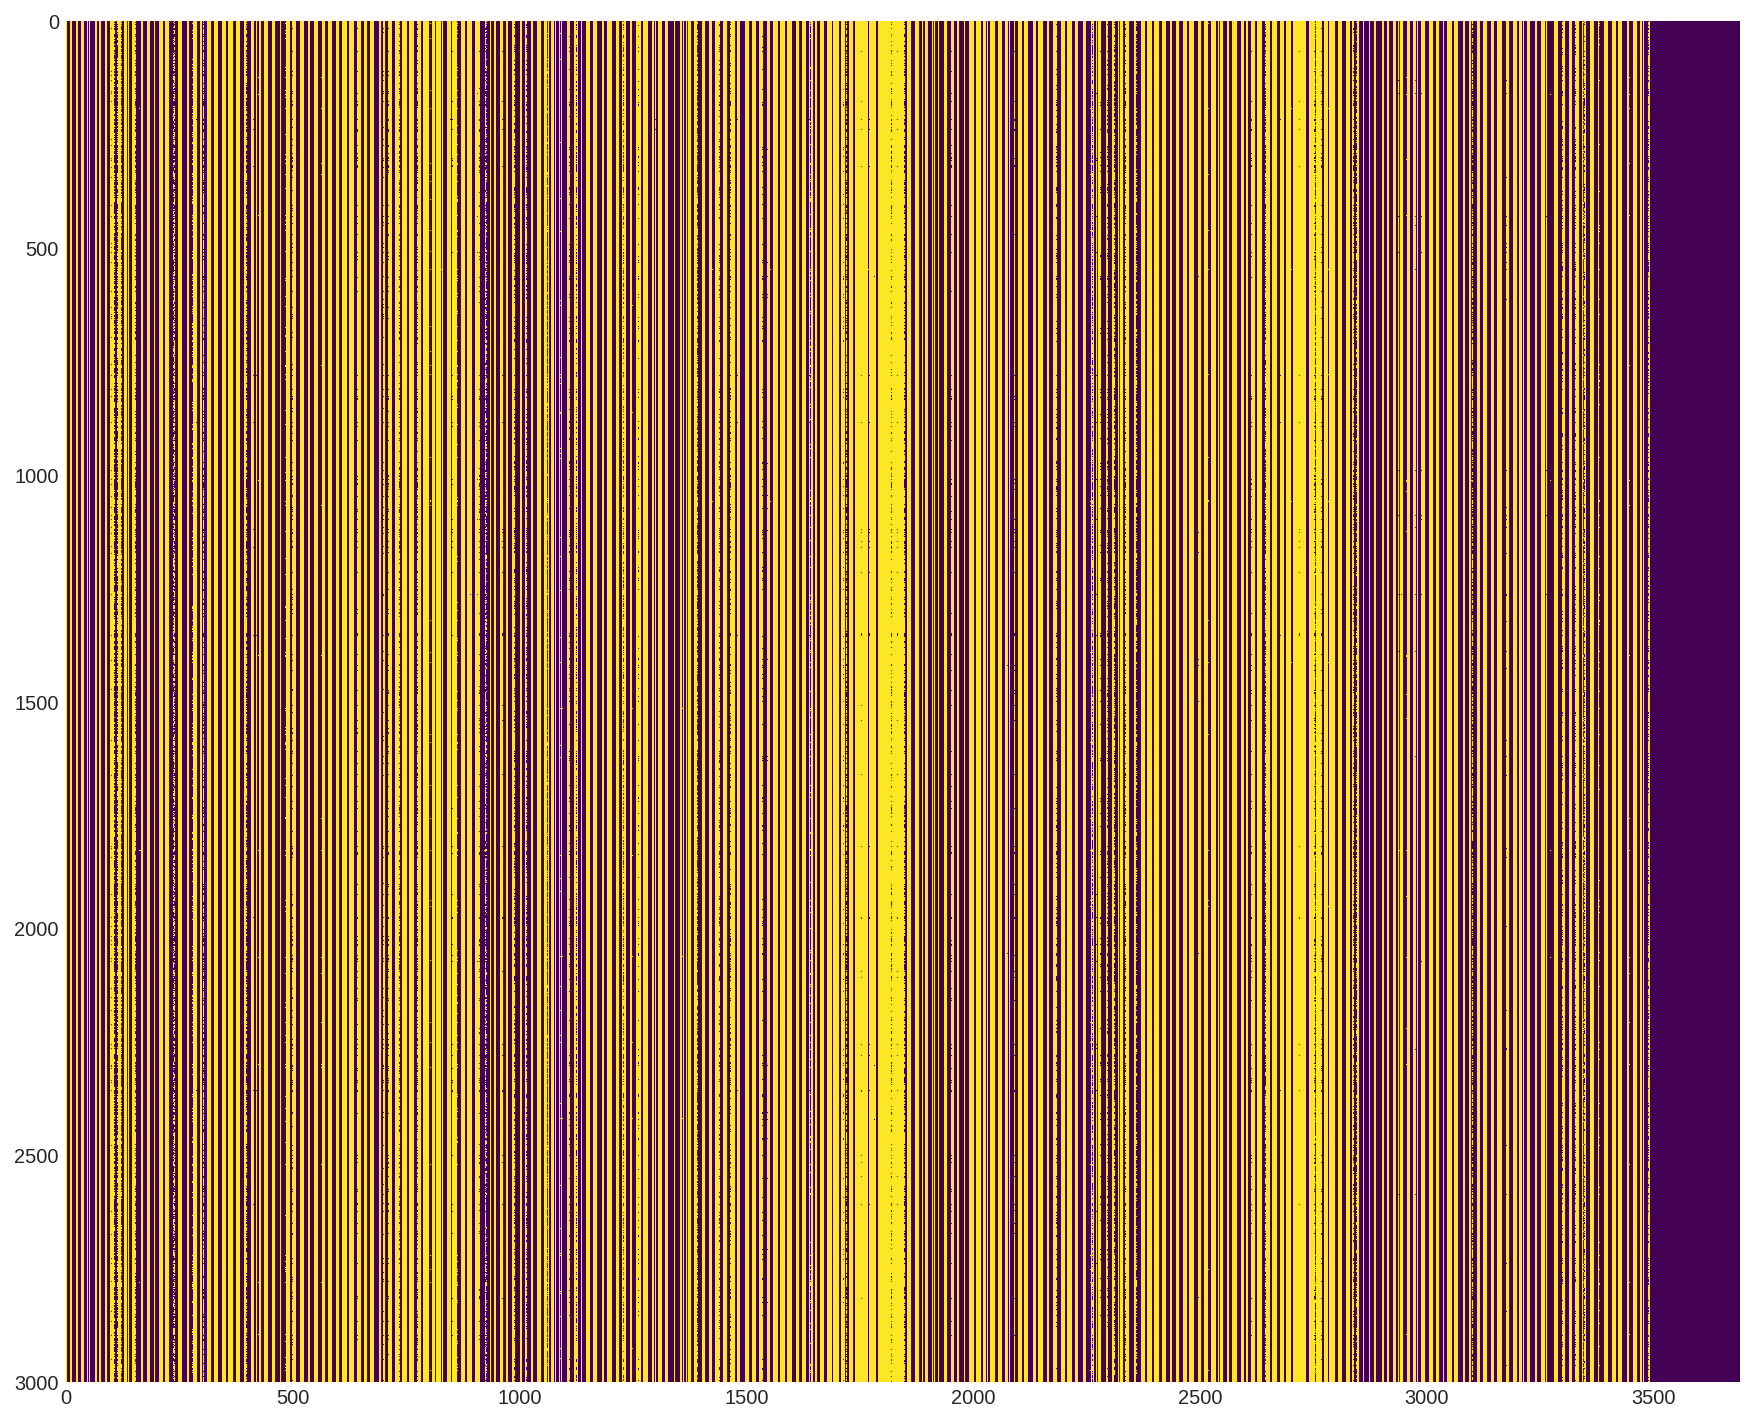

In [25]:
_, ax=plt.subplots(1, 1, figsize=(15, 18))
ax.imshow(category_post, cmap='viridis')
ax.grid('off');

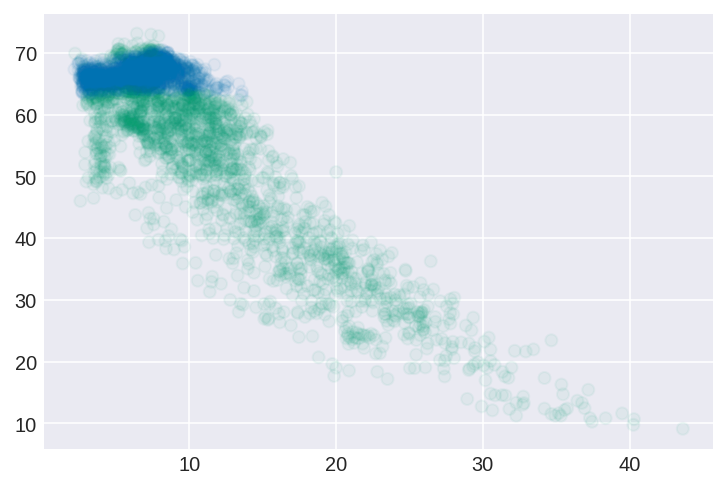

In [26]:
indc = category_post.mean(axis=0).round().astype(int)
cc = np.array([C1, C0])
plt.scatter(X, Y, c=cc[indc], alpha=.05);

# Non-marginalized mixture

In [27]:
n =  X.shape[0]                                         
with pm.Model() as gmm2:
    # Proportion in each mixture
    π = pm.Dirichlet('π', np.array([1]*k), testval=np.ones(k)/k)

    # Priors for unknown model parameters
    α = pm.Normal('α', mu=0, sd=100, shape=k, 
                  testval=np.array([Y.mean()]*2)) #Intercept
    β = pm.Normal('β', mu=0, sd=100, shape=k) 
    σ  = pm.HalfCauchy('σ', 5, shape=k)  #Noise

    # Classifying each observation
    c = pm.Categorical('category', p=π, shape=n)

    mu = α[c] + β[c]*X

    # Likelihood 
    likelihood = pm.Normal('likelihood', mu=mu, sd=σ[c], observed=Y)

In [28]:
with gmm2:
    step1 = pm.NUTS([π, α, β, σ])
    step2 = pm.ElemwiseCategorical([c], values=range(k))
    trace2 = pm.sample(1000, tune=1000, step=[step1, step2])

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: ElemwiseCategorical is deprecated, switch to CategoricalGibbsMetropolis.
  This is separate from the ipykernel package so we can avoid doing imports until
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [σ_log__, β, α, π_stickbreaking__]
>ElemwiseCategorical: [category]
 97%|█████████▋| 1942/2000 [01:53<00:03, 17.17it/s]/home/laoj/Documents/Github/pymc3/pymc3/step_methods/hmc/nuts.py:452: UserWarning: The acceptance probability in chain 2 does not match the target. It is 0.888994168058, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
 97%|█████████▋| 1946/2000 [01:53<00:03, 17.17it/s]/home/laoj/Documents/Github/pymc3/pymc3/step_methods/hmc/nuts.py:452: UserWarning: The acceptance probability in chain 3 does not match the target. It is 0.885704270124, but should be close to 0.8. Try to increase the number of tuning s

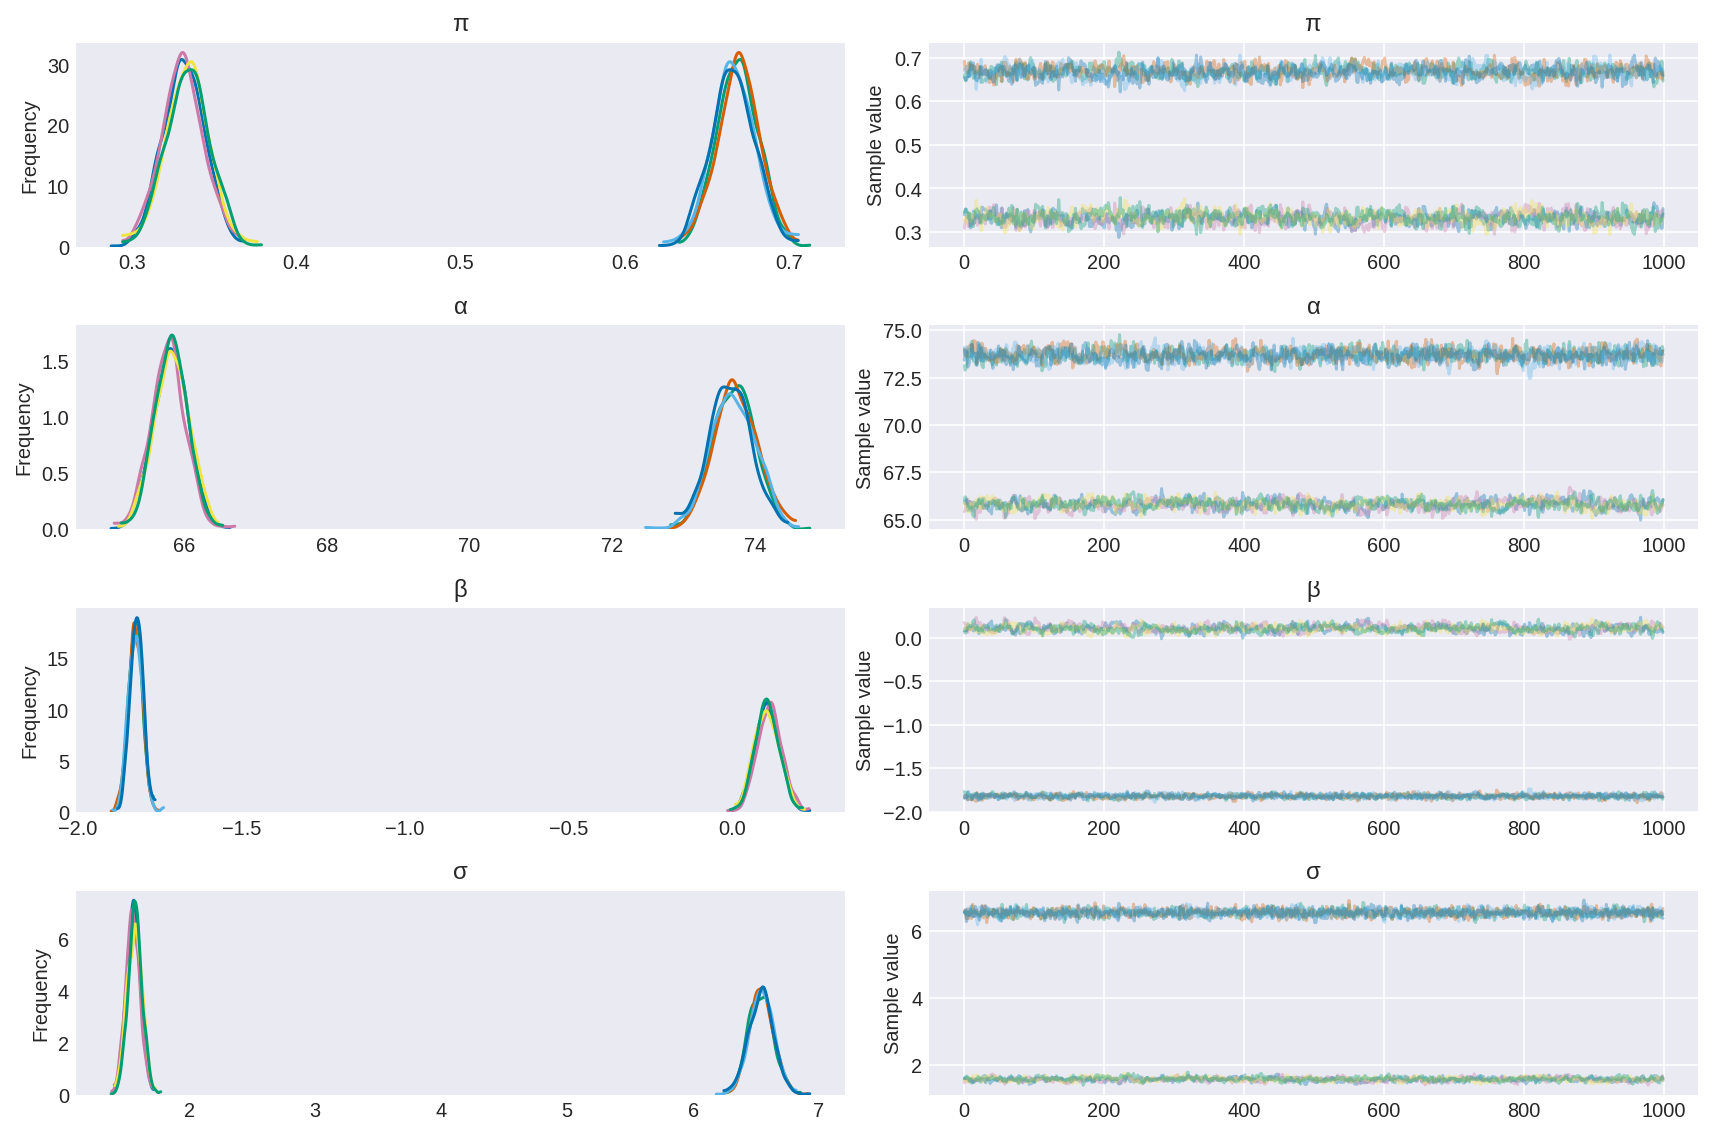

In [29]:
pm.traceplot(trace2, varnames=['π', 'α', 'β', 'σ']);

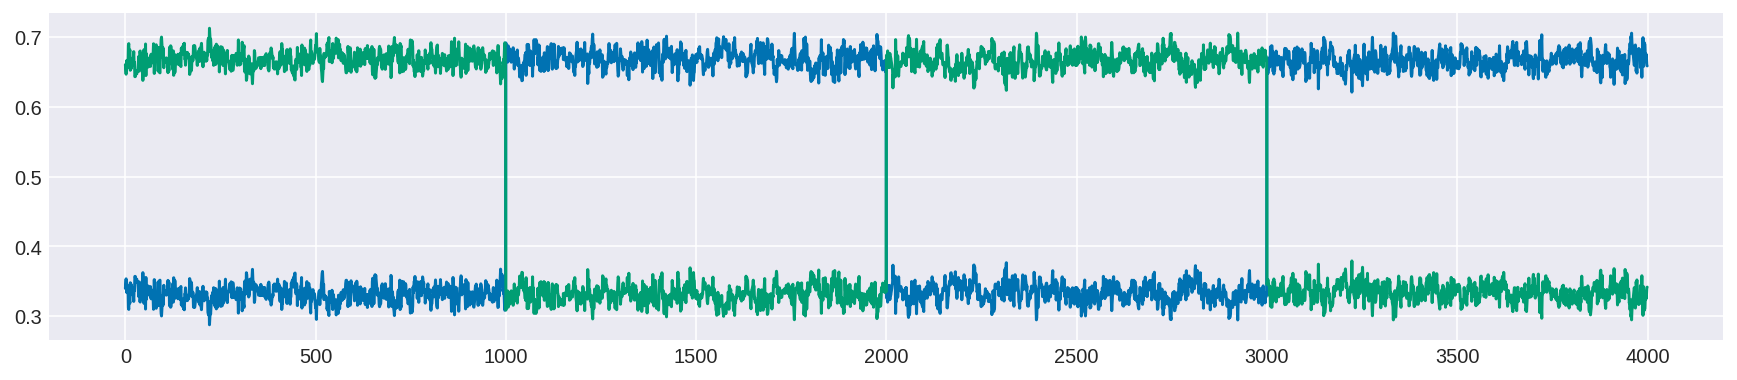

In [30]:
_, ax = plt.subplots(1, 1, figsize=(15, 3))
plt.plot(trace2.get_values(varname='π'));

### Again, switching label by hand

In [31]:
labelswitch = [0, 2]
rmchain = []

In [32]:
diag_switch(trace2, labelswitch, rmchain, ['π', 'α', 'β', 'σ'], pm.gelman_rubin)

{'α': array([ 1.00551891,  1.00352265]),
 'β': array([ 1.00315659,  1.00609284]),
 'π': array([ 1.00769475,  1.00769475]),
 'σ': array([ 1.00028777,  1.01030799])}

In [33]:
diag_switch(trace2, labelswitch, rmchain, ['π', 'α', 'β', 'σ'], pm.effective_n)

{'α': array([ 815.,  407.]),
 'β': array([ 1212.,   335.]),
 'π': array([ 508.,  508.]),
 'σ': array([ 2241.,   393.])}

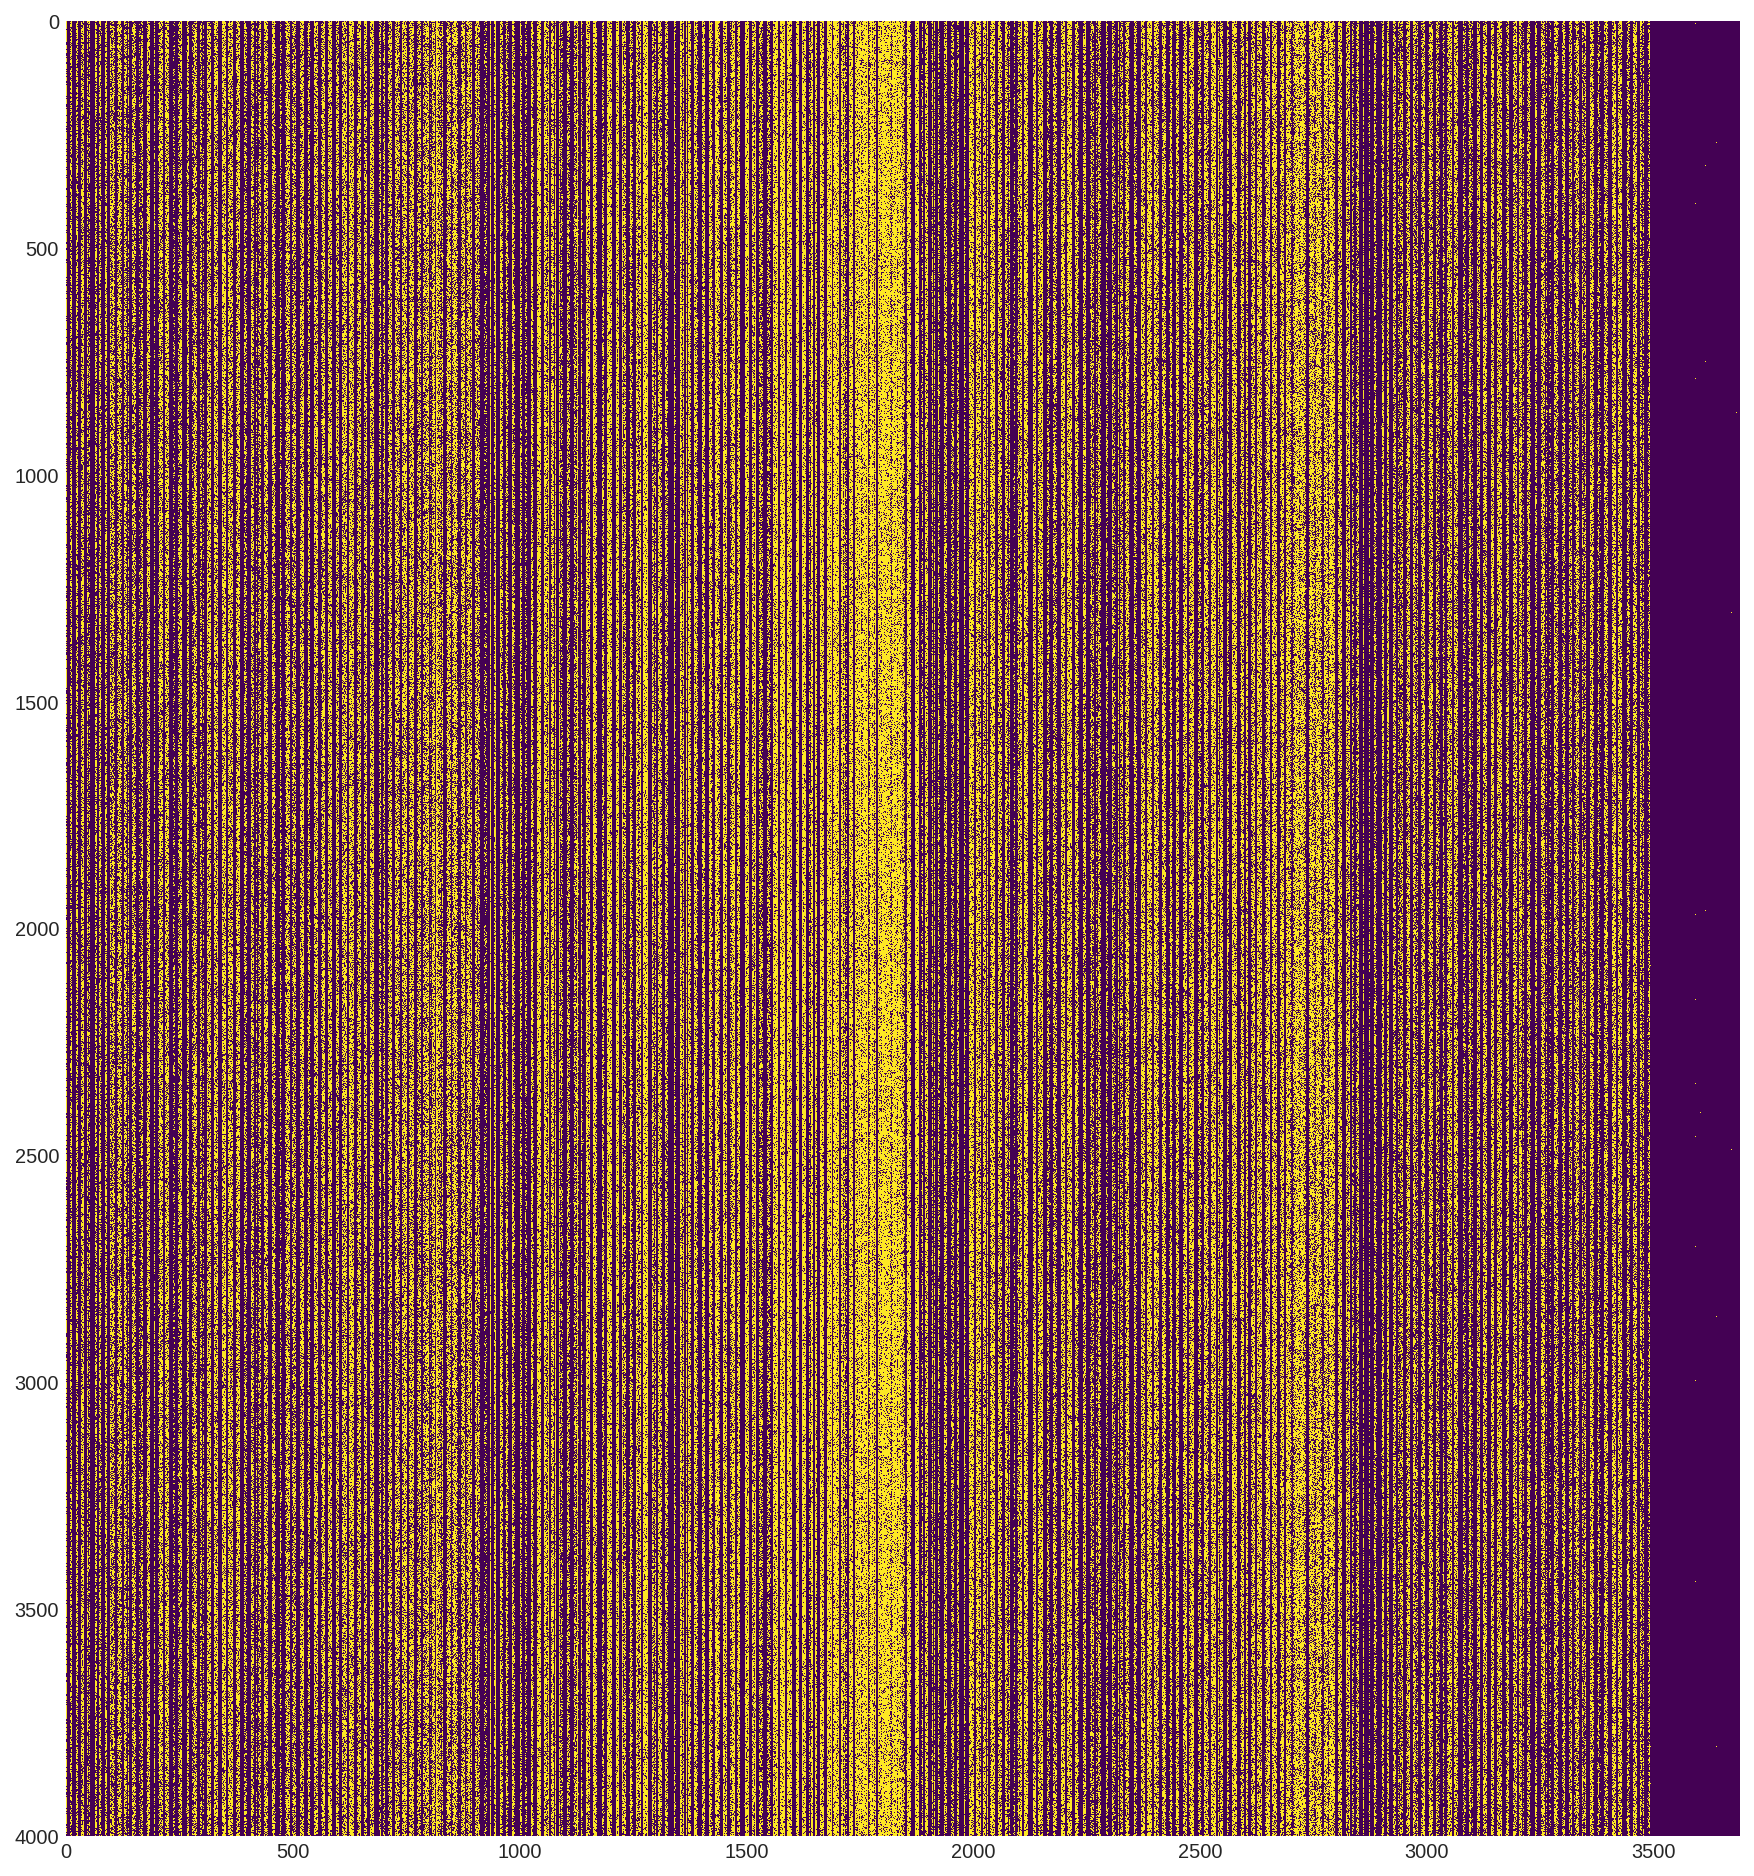

In [34]:
post_ = trace2.get_values(varname='category', combine=False)
x = np.copy(post_)
nchains = trace2.nchains

for il in labelswitch:
    x[il] = 1 - post_[il]
mask = np.ones_like(x).astype(bool)
mask[np.s_[rmchain,:,:]] = False
x = x[mask].reshape((nchains-len(rmchain)), len(trace2), -1)

category_post = np.asarray(x)
category_post = np.reshape(category_post, ((nchains-len(rmchain))*len(trace2), Y.shape[0]))

_, ax=plt.subplots(1, 1, figsize=(15, 18))
ax.imshow(category_post, cmap='viridis')
ax.grid('off');

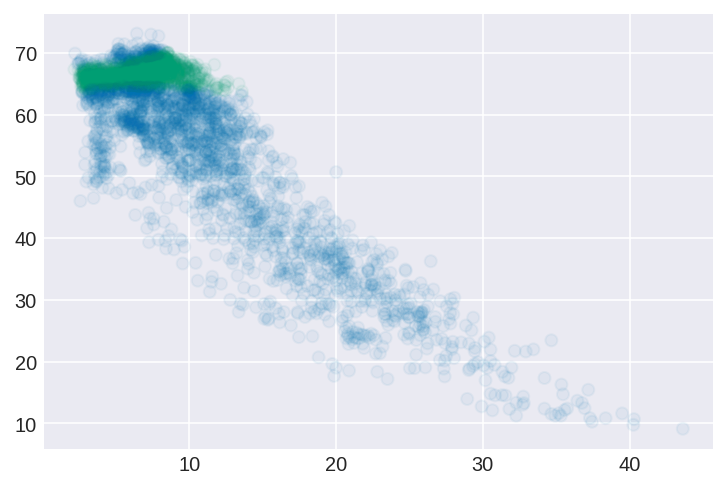

In [35]:
indc = category_post.mean(axis=0).round().astype(int)
cc = np.array([C0, C1])
plt.scatter(X, Y, c=cc[indc], alpha=.05);

# Test new sampler

In [40]:
with gmm2:
    step1 = pm.DEMetropolis([π, α, β, σ, c])
    trace2 = pm.sample(1000, tune=1000, njobs=50, step=[step1], parallelize=False)




 95%|█████████▌| 1905/2000 [01:15<00:03, 25.28it/s]


 95%|█████████▌| 1908/2000 [01:15<00:03, 25.28it/s]


 96%|█████████▌| 1911/2000 [01:15<00:03, 25.28it/s]


 96%|█████████▌| 1914/2000 [01:15<00:03, 25.28it/s]


 96%|█████████▌| 1917/2000 [01:15<00:03, 25.28it/s]


 96%|█████████▌| 1920/2000 [01:15<00:03, 25.27it/s]


 96%|█████████▌| 1923/2000 [01:16<00:03, 25.28it/s]


 96%|█████████▋| 1926/2000 [01:16<00:02, 25.28it/s]


 96%|█████████▋| 1929/2000 [01:16<00:02, 25.28it/s]


 97%|█████████▋| 1932/2000 [01:16<00:02, 25.28it/s]


 97%|█████████▋| 1935/2000 [01:16<00:02, 25.28it/s]


 97%|█████████▋| 1938/2000 [01:16<00:02, 25.28it/s]


 97%|█████████▋| 1941/2000 [01:16<00:02, 25.28it/s]


 97%|█████████▋| 1944/2000 [01:16<00:02, 25.28it/s]


 97%|█████████▋| 1947/2000 [01:17<00:02, 25.28it/s]


 98%|█████████▊| 1950/2000 [01:17<00:01, 25.28it/s]


 98%|█████████▊| 1953/2000 [01:17<00:01, 25.28it/s]


 98%|█████████▊| 1956/2000 [01:17<00:01, 25.29it/s]


 98%|█████████▊| 1959/200

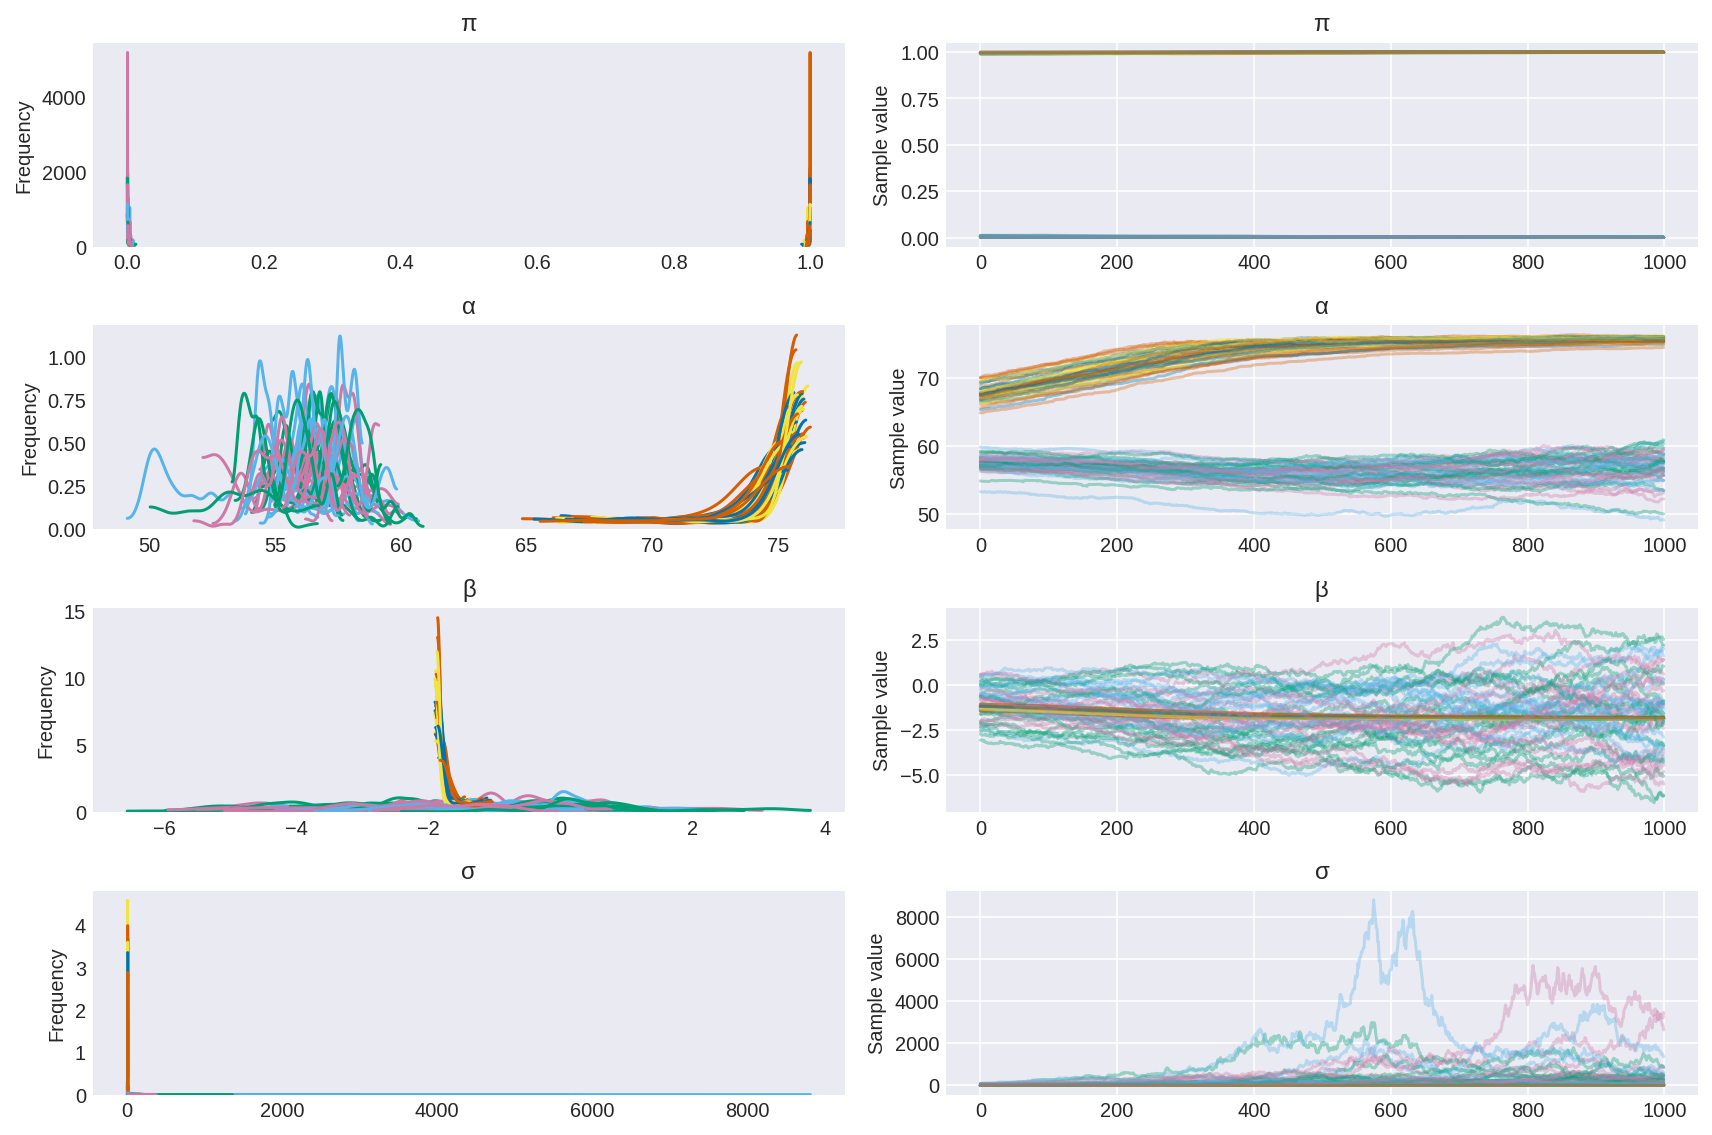

In [41]:
pm.traceplot(trace2, varnames=['π', 'α', 'β', 'σ']);

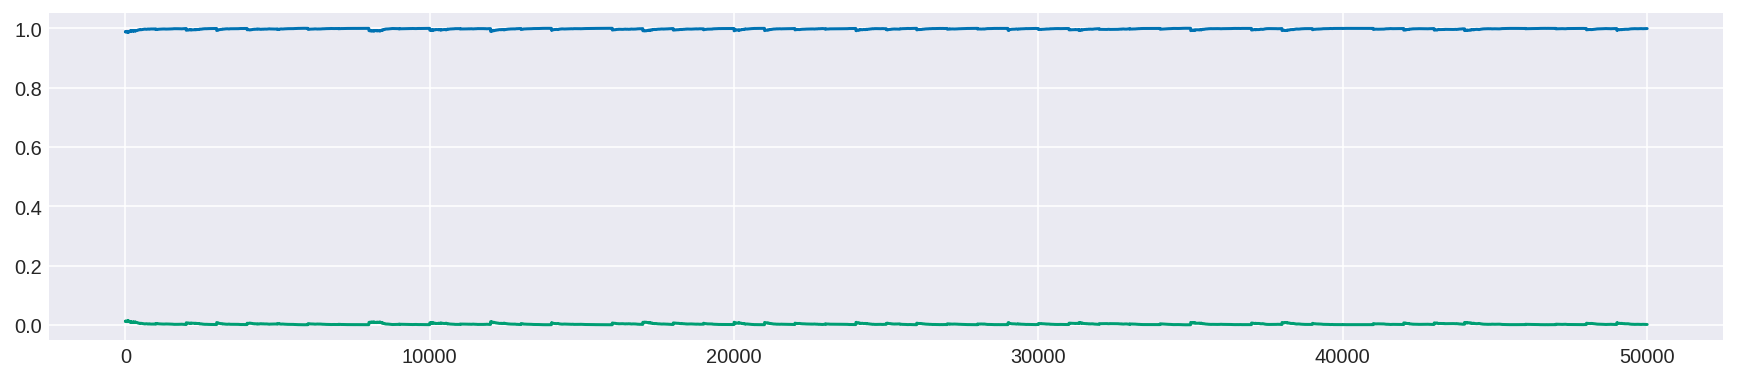

In [42]:
_, ax = plt.subplots(1, 1, figsize=(15, 3))
plt.plot(trace2.get_values(varname='π'));

### Again, switching label by hand

In [100]:
labelswitch = [0]
rmchain = [3]

In [101]:
diag_switch(trace2, labelswitch, rmchain, ['π', 'α', 'β', 'σ'], pm.gelman_rubin)

{'α': array([ 1.00233638,  1.00539723]),
 'β': array([ 1.00084743,  1.00616829]),
 'π': array([ 1.00239785,  1.00239785]),
 'σ': array([ 1.00038834,  1.00150013])}

In [102]:
diag_switch(trace2, labelswitch, rmchain, ['π', 'α', 'β', 'σ'], pm.effective_n)

{'α': array([ 510.,  393.]),
 'β': array([ 718.,  333.]),
 'π': array([ 495.,  495.]),
 'σ': array([ 1777.,   387.])}

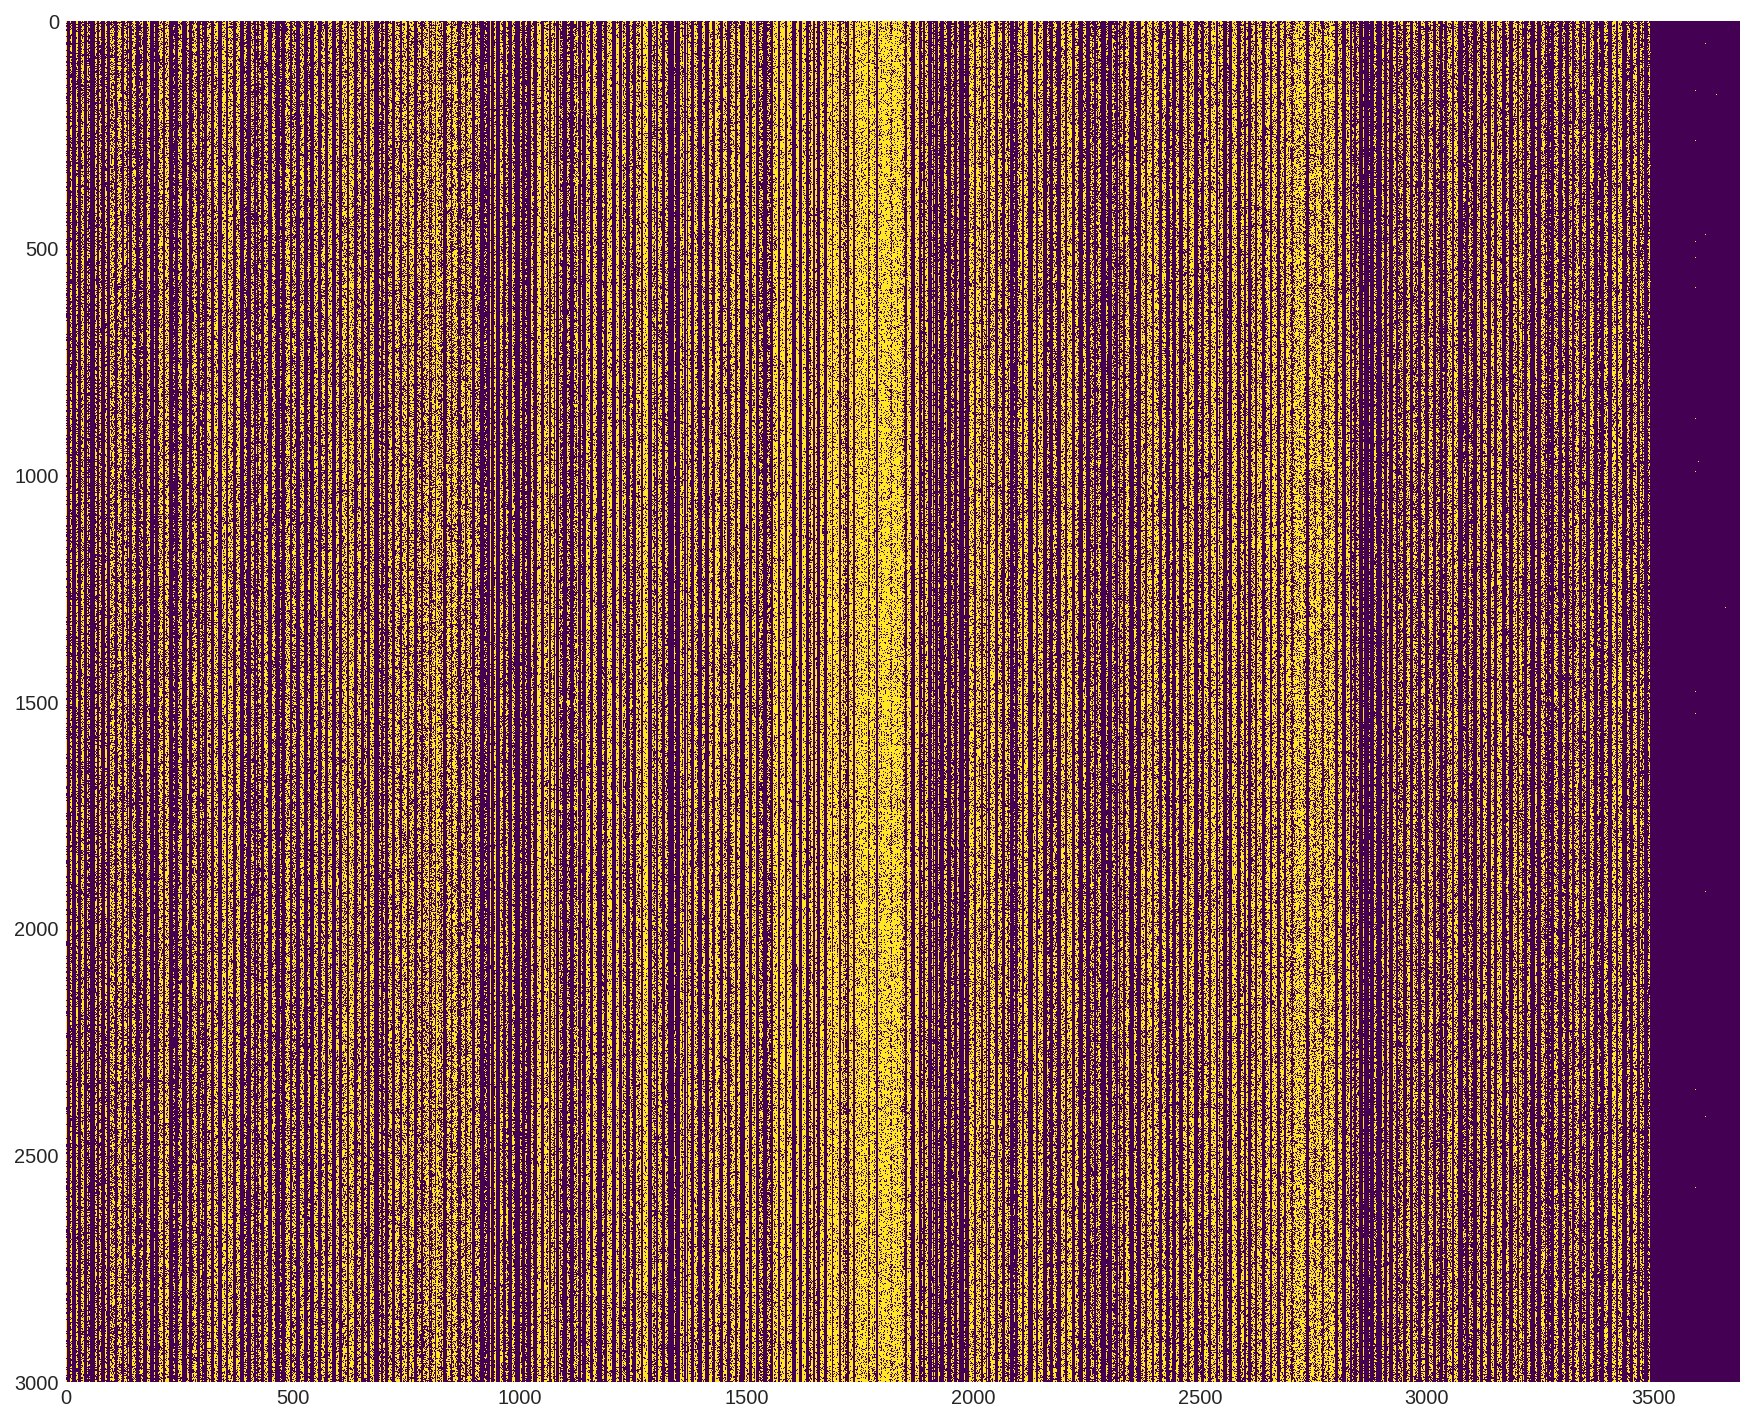

In [103]:
post_ = trace2.get_values(varname='category', combine=False)
x = np.copy(post_)
nchains = trace2.nchains

for il in labelswitch:
    x[il] = 1 - post_[il]
mask = np.ones_like(x).astype(bool)
mask[np.s_[rmchain,:,:]] = False
x = x[mask].reshape((nchains-len(rmchain)), len(trace2), -1)

category_post = np.asarray(x)
category_post = np.reshape(category_post, ((nchains-len(rmchain))*len(trace2), Y.shape[0]))

_, ax=plt.subplots(1, 1, figsize=(15, 18))
ax.imshow(category_post, cmap='viridis')
ax.grid('off');

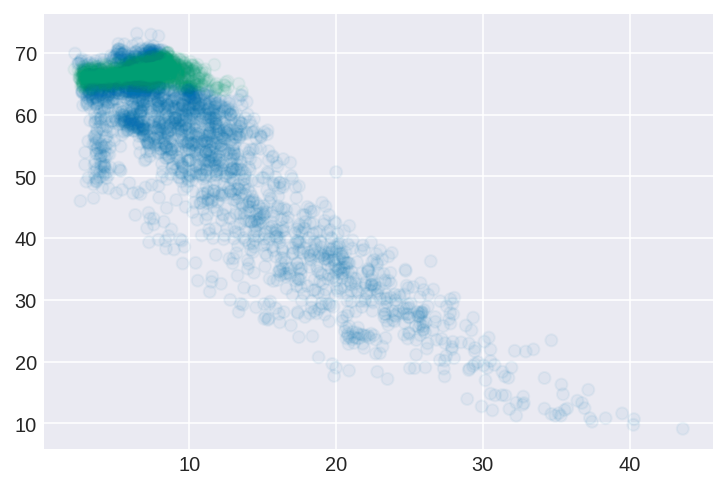

In [104]:
indc = category_post.mean(axis=0).round().astype(int)
cc = np.array([C0, C1])
plt.scatter(X, Y, c=cc[indc], alpha=.05);

In [ ]:
import sys, IPython, scipy, matplotlib, platform
print("This notebook was createad on a computer %s running %s and using:\nPython %s\nIPython %s\nPyMC3 %s\nNumPy %s\nSciPy %s\nMatplotlib %s\nSeaborn %s\n" % (platform.machine(), ' '.join(platform.linux_distribution()[:2]), sys.version[:5], IPython.__version__, pm.__version__, np.__version__, scipy.__version__, matplotlib.__version__, sns.__version__))